# Mask Detection using CNN

### Dataset 

> Link - https://drive.google.com/file/d/1v5WDubjHABvOIeQ4YLfZk8_IlxumKDiw/view?usp=sharing

* Importing the dataset Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

!unzip "/content/gdrive/My Drive/dataset.zip"

Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/dataset/with_mask/._with_mask245.jpg  
  inflating: dataset/with_mask/0_0_7 copy 23.jpg  
  inflating: __MACOSX/dataset/with_mask/._0_0_7 copy 23.jpg  
  inflating: dataset/with_mask/1_0_13 2.jpg  
  inflating: __MACOSX/dataset/with_mask/._1_0_13 2.jpg  
  inflating: dataset/with_mask/with_mask523.jpg  
  inflating: __MACOSX/dataset/with_mask/._with_mask523.jpg  
  inflating: dataset/with_mask/0_1_3.jpg  
  inflating: __MACOSX/dataset/with_mask/._0_1_3.jpg  
  inflating: dataset/with_mask/with_mask537.jpg  
  inflating: __MACOSX/dataset/with_mask/._with_mask537.jpg  
  inflating: dataset/with_mask/with_mask251.jpg  
  inflating: __MACOSX/dataset/with_mask/._with_mask251.jpg  
  inflating: dataset/with_mask/0_0_6 copy 5.jpg  
  inflating: __MACOSX/dataset/with_mask/._0_0_6 copy 5.jpg  
  inflating: dataset/with_mask/1_0_02d05fcb310c887fe31e5f63aa122d1e.jpg  
  inflating: __MACOSX/dataset/with_mask/._1_0_02d05fcb310

### Importing the libraries

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization ,Dropout
from keras.optimizers import Adam, SGD
from keras.callbacks import Callback
from keras.preprocessing.image import ImageDataGenerator

> Setting the Directory

In [ ]:
dataset_dir = 'dataset/'
with_mask = 'dataset/with_mask'
without_mask = 'dataset/without_mask'

> Checking the number of images in each of the directory.

In [ ]:
print("Number of images with mask. ", len(os.listdir(with_mask)))
print("Number of images without mask. ", len(os.listdir(without_mask)))

Number of images with mask.  1916
Number of images without mask.  1919


> Getting the name of the image file in each directory

In [ ]:
print(os.listdir(with_mask)[0])
print(os.listdir(without_mask)[0])

with_mask357.jpeg
1_0_liushishi_0091.jpg


* Determiming the image shape of the images present

In [ ]:
with_mask_image = os.path.join(with_mask, 'with_mask357.jpeg')
without_mask_image = os.path.join(without_mask, '1_0_liushishi_0091.jpg')

w_mask = mpimg.imread(with_mask_image)
o_mask = mpimg.imread(without_mask_image)

print("Image shape of images with mask: ", w_mask.shape)
print("Image shape of images without mask: ", o_mask.shape)

Image shape of images with mask:  (1333, 2000, 3)
Image shape of images without mask:  (129, 143, 3)


* Calculating the mean of the image size

In [ ]:
dim1 = []
dim2 = []
for image_filename in os.listdir('dataset/with_mask'):

    if(image_filename != ".DS_Store"):  
      img = mpimg.imread('dataset/with_mask'+'/'+image_filename)
      d1,d2,colors = img.shape
      dim1.append(d1)
      dim2.append(d2)

In [ ]:
print(np.mean(d1))
print(np.mean(d2))

278.0
151.0


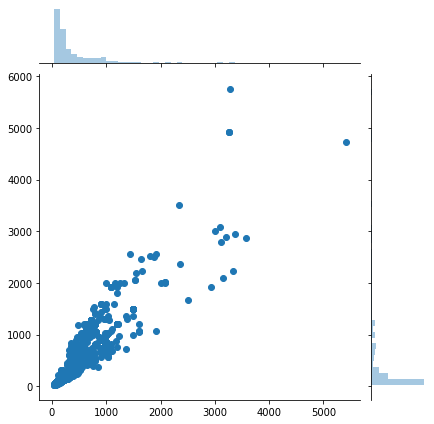

In [ ]:
sns.jointplot(dim1,dim2)

In [ ]:
din1 = []
din2 = []
for image_filename in os.listdir('dataset/without_mask'):

    if(image_filename != ".DS_Store"):  
      img = mpimg.imread('dataset/without_mask'+'/'+image_filename)
      d1,d2,colors = img.shape
      din1.append(d1)
      din2.append(d2)

In [ ]:
print(np.mean(d1))
print(np.mean(d2))

144.0
141.0


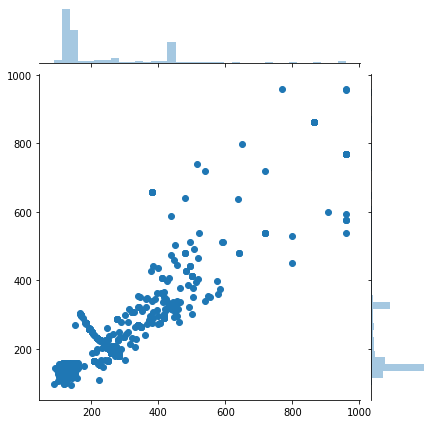

In [ ]:
sns.jointplot(din1,din2)

In [ ]:
image_size = (130, 130)  #Setting the image size

## Data Preprocessing

Image size is 130x130

As you may already know, data that goes into neural networks should usually be normalized in some way to make it more amenable to processing by the network. (It is uncommon to feed raw pixels into a convnet.) In our case, we will preprocess our images by normalizing the pixel values to be in the `[0, 1]` range (originally all values are in the `[0, 255]` range).

In Keras this can be done via the `keras.preprocessing.image.ImageDataGenerator` class using the `rescale` parameter. This `ImageDataGenerator` class allows you to instantiate generators of augmented image batches (and their labels) via `.flow(data, labels)` or `.flow_from_directory(directory)`. These generators can then be used with the Keras model methods that accept data generators as inputs: `fit`, `evaluate_generator`, and `predict_generator`.

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=20,       # Rotate the image 20 degrees
    width_shift_range=0.10,  # Shift the image width by a max of 5%
    height_shift_range=0.10, # Shift the image height by a max of 5%
    rescale=1./255,          # Rescale the image by normalzing it.
    shear_range=0.1,         # Shear means cutting away part of the image (max 10%)
    zoom_range=0.1,          # Zoom in by 10% max
    horizontal_flip=True,    # Allow horizontal flipping
    fill_mode='nearest'      # Fill in missing pixels with the nearest filled value
)

train_gen = datagen.flow_from_directory(
    dataset_dir,
    target_size=image_size,
    batch_size=128,
    color_mode='rgb',
    class_mode='binary'
)

validation_gen = datagen.flow_from_directory(
    dataset_dir,
    target_size=image_size,
    batch_size=128,
    color_mode='rgb',
    class_mode='binary'
)

Found 3833 images belonging to 2 classes.
Found 3833 images belonging to 2 classes.


## Exporting the labels.txt

In [ ]:
print (train_gen.class_indices)

labels = '\n'.join(sorted(train_gen.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels)

{'with_mask': 0, 'without_mask': 1}


## Creating the Model

In [ ]:
model = Sequential()

model.add(Conv2D(filters=16, kernel_size=(3,3), input_shape=image_size+(3,), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=image_size+(3,), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=image_size+(3,), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), input_shape=image_size+(3,), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), input_shape=image_size+(3,), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

## Summary of the model

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 16)      448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 62, 62, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 12, 64)       

## Fitting the model

In [ ]:
model.fit_generator(train_gen, epochs=50, validation_data=validation_gen)

30/30 [==============================] - 51s 2s/step - loss: 0.0615 - accuracy: 0.9770 - val_loss: 0.0461 - val_accuracy: 0.9791
Epoch 33/50
30/30 [==============================] - 51s 2s/step - loss: 0.0622 - accuracy: 0.9781 - val_loss: 0.0648 - val_accuracy: 0.9828
Epoch 34/50
30/30 [==============================] - 51s 2s/step - loss: 0.0667 - accuracy: 0.9747 - val_loss: 0.0341 - val_accuracy: 0.9807
Epoch 35/50
30/30 [==============================] - 52s 2s/step - loss: 0.0675 - accuracy: 0.9763 - val_loss: 0.0920 - val_accuracy: 0.9799
Epoch 36/50
30/30 [==============================] - 51s 2s/step - loss: 0.0701 - accuracy: 0.9734 - val_loss: 0.0370 - val_accuracy: 0.9789
Epoch 37/50
30/30 [==============================] - 52s 2s/step - loss: 0.0521 - accuracy: 0.9820 - val_loss: 0.0299 - val_accuracy: 0.9843
Epoch 38/50
30/30 [==============================] - 51s 2s/step - loss: 0.0509 - accuracy: 0.9823 - val_loss: 0.0261 - val_accuracy: 0.9817
Epoch 39/50
30/30 [======

> Model training is done, it's accuracy is 98.2% and loss is 4.8% whereas it's validation loss is 4.6% and validation accuracy is 98.5%

## Saving the model

In [ ]:
model.save('mymodel.h5')

## Testing the model with images

In [ ]:
import numpy as np

from google.colab import files
from keras.preprocessing import image

uploaded=files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path='/content/' + fn
  img=image.load_img(path, target_size=(130, 130))
  
  x=image.img_to_array(img)
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])
  
  classes = model.predict(images, batch_size=128)
  
  print(classes)
  
  if classes[0]>0:
    print(fn + " is a without mask")
    
  else:
    print(fn + " is a with mask")

Saving 7.jpg to 7.jpg
[[0.]]
7.jpg is a with mask


## Converting the model into tflite and exporting it

In [ ]:
import tensorflow as tf

model = tf.keras.models.load_model('mymodel.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("converted_model.tflite", "wb").write(tflite_model)

414920